<a href="https://colab.research.google.com/github/JasperJZhou/DH100Proj/blob/working_6%2F13/DIGHUM100PROJ_JasperZhou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**0) IMPORT STATEMENTS**

Importing Data Analysis Tools and mounting the Google Drive

In [1]:
#Mounting Google Drive:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Jasper Zhou/' #Change this to your root path
drive.mount("/content/gdrive", force_remount=True) 


Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
#IMPORT STATEMENTS:

#General data analysis tools 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

#NLTK Tools
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


import nltk
nltk.download('punkt')
import nltk.tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import re #regular expression

#Model Building Tools:
from sklearn.model_selection import train_test_split

#Classification Algorithms
from sklearn.naive_bayes import MultinomialNB #Naive Bayes
from sklearn import svm #Support Vector Machine
from sklearn import linear_model #Logistic Regression

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##**I) LOADING THE DATASET:**
Create a DataFrame using pandas with our downloaded data (in folder marked data)


In [3]:
true_df = pd.read_csv(root_path + '/data/True.csv') #DataFrame with True headlines (Is Not Fake News)
fake_df = pd.read_csv(root_path + '/data/Fake.csv') #DataFrame with Fake headlines (Is Fake News)

In [4]:
#Label our data (1 for fake news, 0 for true news)
true_df["Is_Fake"] = np.zeros(true_df.shape[0])
fake_df["Is_Fake"] = np.ones(fake_df.shape[0])

In [5]:
#Combine DataFrames into a CombinedFrame:
combined_df = true_df.append(fake_df).sample(frac = 1) #randomize our data
combined_df.head()

,title,text,subject,date,Is_Fake
14144,"Zimbabwe's Mnangagwa arrives home, to be sworn...",HARARE (Reuters) - Zimbabwe s former vice pres...,worldnews,"November 22, 2017",0.0
312,Democrat Takes Trump To The Woodshed In Fiery...,Donald Trump is getting absolutely hammered fo...,News,"September 25, 2017",1.0
13962,OUCH! BUSH “BESTIE” Goes Against GOP Elites…EN...,That s gonna leave a mark Former Vice Presiden...,politics,"May 7, 2016",1.0
3589,Trump Supporters Already Regret Voting For Hi...,Let s all point and laugh at the SAD Trump sup...,News,"December 3, 2016",1.0
15983,WHY THE HUGE 1.1 MILLION DROP in Food Stamp En...,OVER 1 MILLION PEOPLE HAVE DROPPED OFF OF THE ...,Government News,"Aug 8, 2017",1.0


##**II)INTRODUCTION**

#Project Statement
The goal of this project is two-fold:

A)Can we analyze how the rhetoric around fake news has changed throughout time?

B)Can we create an effective model to classify fake and real news?

#Background

To start, a definition of fake news is needed. While many definitions exist, a good, succinct one comes from the University of Michigan's library, which defines fake news "as those news stories that are false: the entire story itself is fabricated, with no verifiable facts, sources or quotes" (Source: [University of Michigan](https://guides.lib.umich.edu/fakenews)).

Fake news has recently taken center stage in the public conciousness, popularized by tweets by Donald Trump in the run up to the 2016 presidential election. However, this project will not focus on the media relations of Donald Trump. Instead, this project will focus on the nature of fake news itself in terms of content.

Fake news is not a recent or unique issue, although it has been exacerbated by the ease and speed in which information could be spread. Since the 1890s, fake news has plagued the profession of journalism. Dubbed "yellow journalism", newspaper publishers would run sensationlistic news articles. However, fake news was eventually replaced by objective journalism, until recently due to the rise of the internet. (Source: [UCSB](https://www.cits.ucsb.edu/fake-news/brief-history)).

Unfortunately, the future seems bleak for traditional, objective news outlets. In 2016, Politico reported the findings of the Pew Research Center's "State of the Media 2016", noted that "[a]dvertising revenue is down; staffs continue to get cut; the number of newspapers has declined by 100 since 2004". (Source: Politico). As a result, we are moving towards a new world "where the majority of the population does not reply on professionally reported news sources" (Source: [Politico](https://www.politico.com/magazine/story/2016/12/fake-news-history-long-violent-214535)).

In terms of impacts fake news has on society, University of Michigan lists the following as possibility:

**A) Anti-intellectualism:** We have seen during this past year due to COVID-19, fake social media stories have run amok spanning from fake treatments to vaccine scares. Often, these issues stem from a distrust of domain knowledge experts. For example, according to a letter written to NCBI, several incidents exemplified this. In a particularly greivious instance in Mexico:


> [T]here have been reports of health personnel having hot coffee or bleach thrown at them on the streets, as well as attempts to burn their homes, and even beatings of nurses and doctors; in some towns, the habitants have even arranged to burn COVID-19-designated hospitals. (Source: [NCBI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7722992/))

**B)Antiscience:** Similar to anti-intellectualism, there has been a startling rise in anti-scientific theories. For example, the Flat Earth movement has demonstrated the power of social media in overturning what used to be a universally accepted truth. In an interview with Scientific American, Michael Marshall noted that the Flat Earth movement's rise is closely correlated with the technology we have available. In his interview, a contributing factor was Youtube's video recommendation algorithm. It became very easy for individuals, who were only curious, to quickly get recommended similar videos, reinforcing their beliefs. (Source: [Scientific American](https://www.scientificamerican.com/podcast/episode/flat-earthers-what-they-believe-and-why/))

**C)Widespread Mistrust:** In 2016, the BBC interviewed Robert Proctor who had been studying the rhetoric surrounding tobacco advertisements. The goal of these tobacco advertisements were not necessarily to discredit scientific literature and studies, but to create enough doubt surrounding the scientific community at large. Prior to 2016, similar strategies were used surrounding Barack Obama's birth certificate. While Obama was undoubtedly American, the rumor successfully created enough doubt around Obama's birth place to create an unncessarily harmful and dangerous scandal. (Source: [BBC](https://www.bbc.com/future/article/20160105-the-man-who-studies-the-spread-of-ignorance))



##**III) EDA (Exploratory Data Analysis) and Data Cleaning**




#i)Intial Pre-processing:
First, we must pre-process the text to create text that is easily machine-readable. To do so, we undergo the following steps:


1. Lowercase all text
2. Tokenize the sentence into individual words
3. Remove the stop words

From this, we can do some initial, basic data analysis and examine the differences between real and fake news.


---

First, create a small subset to develop our pipeline.


In [6]:
def remove_punctuation (text_array):
  #This function removes the punctuation of text after tokenizing everything
  arr = [text for text in text_array if text not in string.punctuation]
  return arr

In [7]:
#Convert the date to datetime objects
from datetime import datetime

def convert_date(date_string):
  num_array = str(np.arange(0, 10))

  #For cases of short string month day, year (e.g. Jan 19, 2020)
  if re.findall(r'[A-Z][a-z]{2} \d{1,2}, \d{4}', date_string):
    try:
      date = datetime.strptime(date_string, '%b %d, %Y') #without space
    except ValueError:
      date = datetime.strptime(date_string, '%b %d, %Y ') #with space

  #For cases of long string month day, year (e.g. January 19, 2020)
  elif re.findall(r'[A-Z][a-z]{2,} \d{1,2}, \d{4}', date_string):
    try:
      date = datetime.strptime(date_string, '%B %d, %Y') #without space
    except ValueError:
      date = datetime.strptime(date_string, '%B %d, %Y ') #with space
  
  #For cases of short month-day-year (e.g. Jan-19-2020)
  elif re.findall(r'[A-Z][a-z]{2}-\d{1,2}-\d{4}', date_string):
    try:
      date = datetime.strptime(date_string, '%b-%d-%Y') #without space
    except ValueError:
      date = datetime.strptime(date_string, '%b-%d-%Y ') #with space

  #For cases of long month-day-year (e.g. January-19-2020)
  elif re.findall(r'[A-Z][a-z]{2,}-\d{1,2}-\d{4}', date_string):
    try:
      date = datetime.strptime(date_string, '%Bb-%d-%Y') #without space
    except ValueError:
      date = datetime.strptime(date_string, '%B-%d-%Y ') #with space
  else:
    date = " "
  return date

In [8]:
def remove_stopwords(text_array):
  arr = [text for text in text_array if text not in ENGLISH_STOP_WORDS]
  return arr

In [9]:
import string
#TESTER: Create small subset of data to test/create our pipeline on.
pre_process_df_test = combined_df.sample(50, replace = False)

In [10]:
#Lowercase all titles and text
pre_process_df_test["title"] = pre_process_df_test["title"].str.lower()
pre_process_df_test["text"] = pre_process_df_test["text"].str.lower()

#tokenize words into individual words and then remove the punctuation
pre_process_df_test["tokenized_title"] = pre_process_df_test["title"].apply(word_tokenize).apply(remove_punctuation)
pre_process_df_test["tokenized_text"] = pre_process_df_test["text"].apply(word_tokenize).apply(remove_punctuation)

#Remove stop words
pre_process_df_test["no_stopwords_title"] = pre_process_df_test["tokenized_title"].apply(remove_stopwords)
pre_process_df_test["no_stopwords_text"] = pre_process_df_test["tokenized_text"].apply(remove_stopwords)

#Convert date string to datetime objects for ease of analysis
pre_process_df_test["new_date"] = pre_process_df_test["date"].apply(convert_date)


---
Now, we can apply our pipeline to our dataframe in general

In [11]:
def pre_process_pipeline(input_df):
  #INPUT: DataFrame containing title, text, subject, date, and Is_Fake (a boolean value with 1 for fake, 0 for true)
  #OUTPUT: DataFrame containing above columns and tokenized title and text
  input_df["processed_title"] = input_df["title"].str.lower().apply(word_tokenize).apply(remove_punctuation).apply(remove_stopwords)
  input_df["processed_text"] = input_df["text"].str.lower().apply(word_tokenize).apply(remove_punctuation).apply(remove_stopwords)
  input_df["date"] = input_df["date"].apply(convert_date)
  return input_df

This seems to work quite well, so we can continue with our EDA on the whole dataset.

---

#ii) Analysis

To start, I want to create a word cloud for true and fake news. To do so, I will apply my pre-processing pipeline to the true and fake news data frames separately.



In [12]:
processed_true_df = pre_process_pipeline(true_df.copy()) #for true news df


In [13]:
processed_fake_df = pre_process_pipeline(fake_df.copy()) #for true news df


In [14]:
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

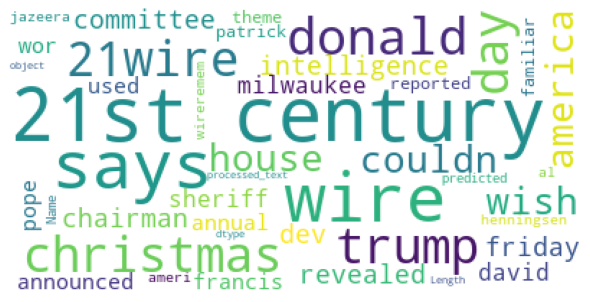

In [15]:
wordcloud_fake = WordCloud(background_color = 'white').generate(str(processed_fake_df["processed_text"]))
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_fake)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

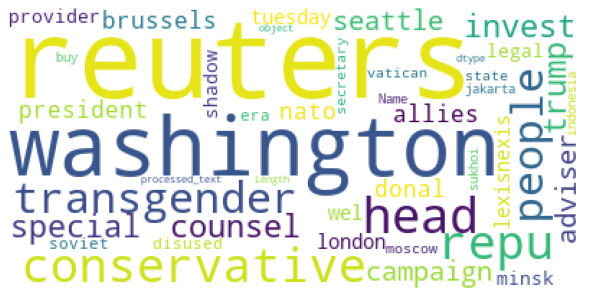

In [16]:
wordcloud_true = WordCloud(background_color = 'white').generate(str(processed_true_df["processed_text"]))
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_true)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

##**IV)SENTIMENT ANALYSIS OF FAKE/REAL NEWS**

In [17]:
#Installing TextBlob for Sentiment Analysis
!pip install -U textblob
!python -m textblob.download_corpora
from textblob import TextBlob

Requirement already up-to-date: textblob in /usr/local/lib/python3.7/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [18]:
def get_polarity(text):
  #Input: sentence or text
  #Output: polarity of sentence
  blob = TextBlob(text)
  return blob.sentiment.polarity

def get_subjectivity(text):
  #Input: sentence or text
  #Output: polarity of sentence
  blob = TextBlob(text)
  return blob.sentiment.subjectivity


In [19]:
processed_true_df["title_polarity"] = processed_true_df["title"].apply(get_polarity)
processed_true_df["title_subjectivity"] = processed_true_df["title"].apply(get_subjectivity)

processed_fake_df["title_polarity"] = processed_fake_df["title"].apply(get_polarity)
processed_fake_df["title_subjectivity"] = processed_fake_df["title"].apply(get_subjectivity)

processed_true_df["text_polarity"] = processed_true_df["text"].apply(get_polarity)
processed_true_df["text_subjectivity"] = processed_true_df["text"].apply(get_subjectivity)

processed_fake_df["text_polarity"] = processed_fake_df["text"].apply(get_polarity)
processed_fake_df["text_subjectivity"] = processed_fake_df["text"].apply(get_subjectivity)

First, I want to look at the distribution of polarity scores of text for fake and real news. 

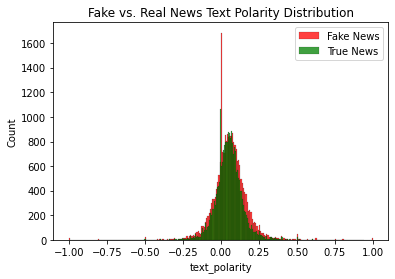

In [20]:
sns.histplot(data = processed_fake_df, x = "text_polarity", color = 'red', label = "Fake News")
sns.histplot(data = processed_true_df, x = "text_polarity", color = 'green', label = "True News")
plt.title("Fake vs. Real News Text Polarity Distribution");
plt.legend();

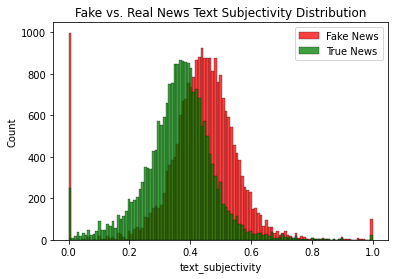

In [21]:
sns.histplot(data = processed_fake_df, x = "text_subjectivity", color = 'red', label = "Fake News")
sns.histplot(data = processed_true_df, x = "text_subjectivity", color = 'green', label = "True News")
plt.title("Fake vs. Real News Text Subjectivity Distribution");
plt.legend();

##**V)PREDICTING FAKE/REAL NEWS**

In [99]:
combined_df_classify = combined_df.copy()

# **i)TF-IDF Transformation:**

Transform the dataframe to a TF-IDF matrix.

In [109]:
X_title = combined_df_classify["title"]
X_text = combined_df_classify["text"]
y = combined_df_classify["Is_Fake"]

In [110]:
tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1,3), 
                     min_df = 0, 
                     stop_words = 'english')
transformed_title = tf.fit_transform(X_title)
transformed_text = tf.fit_transform(X_text)